# Импорт

In [46]:
import gc
import os

import pandas as pd
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier

# Обработка данных

Считывание данных о контрактах

In [47]:
contract_path = os.path.abspath('C:\csv\contracts.csv')
dtypes = {'product_code' : 'category', 
          'customer_legal_form' : 'category', 
          'supplier_legal_form' : 'category', 
          'current_contract_stage' : 'category'}
parse_dates = ['execution_period_start']
data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
gc.collect()
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data['execution_period_end'] = pd.to_datetime(data['execution_period_end'], format = "%Y-%m-%d", errors = 'coerce')
data.head()

C:\Users\Данил\AppData\Local\Temp\ipykernel_12700\3439507682.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
C:\Users\Данил\AppData\Local\Temp\ipykernel_12700\3439507682.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)


,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage
0,39372925,2056104253518000008,2018-01-18T12:25:48.307+03:00,561042535,75203,72500.00,2018-01-18,2018-03-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,561046931,E
1,39141990,2056104253517000135,2018-01-12T11:41:48.714+03:00,561042535,75203,991142.46,2017-10-24,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,561046931,E
2,39452733,2056203249818000006,2018-01-23T09:12:49.012+03:00,562032498,75203,170000.00,2018-01-22,2018-03-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,NaN,56207573829,E
3,39762144,1057000290918000009,2018-01-31T18:50:01.658+03:00,570002909,75104,200000.00,2018-01-29,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,545019120,E
4,39348176,2056207055018000003,2018-01-17T16:47:12.637+03:00,562070550,75204,6393010.00,2017-06-20,2017-09-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,506066768,E


In [48]:
data = data.dropna()

In [49]:
# data = data[(data['execution_period_start'] >= pd.Timestamp(2014,1,1))]

In [50]:
data = data[
    (data['customer_legal_form'] == '65143') |
    (data['customer_legal_form'] == '65243') |
    (data['customer_legal_form'] == '75400') |
    (data['customer_legal_form'] == '75401') |
    (data['customer_legal_form'] == '75403') |
    (data['customer_legal_form'] == '75404')
]

In [51]:
OKOPF_old = {
    '12100' : '10000',
    '12165' : '12300', #Общества с ограниченной ответственностью
    '12166' : '10000',
    '15000' : '65000', #Унитарные предприятия
    '15100' : '65100',  #Унитарные предприятия, основанные на праве оперативного управления (казенные предприятия)
    '15141' : '65141', #Федеральные казенные предприятия
    '15142' : '65142', #Казенные предприятия субъектов Российской Федерации
    '15143' : '65143', #Муниципальные казенные предприятия
    '15200' : '65200', #Унитарные предприятия, основанные на праве хозяйственного ведения
    '15241' : '65241', #Федеральные государственные унитарные предприятия
    '15242' : '65242', #Государственные унитарные предприятия субъектов Российской Федерации
    '15243' : '65243', #Муниципальные унитарные предприятия
    '20114' : 'Not Applicable',
    '20300' : '71500',
    '20400' : '70400', #Фонды
    '20401' : '70401', #Благотворительные фонды
    '20402' : '70402', #Негосударственные пенсионные фонды
    '20403' : '70403', #Общественные фонды
    '20404' : '70404', #Экологические фонды
    '20500' : '20614', #Некоммерческие партнерства
    '20617' : 'Not Applicable',
    '20618' : 'Not Applicable',
    '20701' : '20702',
    '20800' : '20600',
    '20801' : '20609',
    '20802' : '20610',
    '20803' : '20611',
    '20810' : '21200',
    '20816' : '20716',
    '20900' : '75000', #Учреждения
    '20901' : '75000', #Автономные учреждения -> Учреждения, из-за подразделения на уровни в новом ОКОПФ
    '20902' : '75502', #Благотворительные учреждения
    '20903' : '75000', #Бюджетные учреждения, Аналогично Автономным учреждениям
    '20904' : '75000', #Казеннные учреждения, Аналогично Автономным учреждениям
    '20905' : '75505', #Общественные учреждения
    '20906' : '75500', #Учреждения
    '20907' : '75000', #Учреждения акакдемий наук, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '20908' : '75000', #Учреждения религиозных организаций, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '21001' : '20701', #Садоводческие, огороднические или дачные некоммерческие товарищества
    '28000' : 'Not Applicable',   #Иные Некоммерческие организации
    '28001' : '71400', #Автономные некоммерческие организации
    '28002' : '20615',
    '28003' : '75300',
    '28004' : '71602', #Государственные компании
    '28005' : '71601', #Государственные корпорации
    '28006' : '21100', #Казачьи общества -> Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации
    '28007' : '20616',
    '28008' : '20108',
    '28010' : '21200',
    '28012' : '20612',
    '28013' : 'Not Applicable',
    '28014' : '71610',
    '28016' : '20716',
    '28017' : '20217', #Территориальные общественные самоуправления
    '29000' : 'Not Applicable',   #Иные Некоммерческие организации
}

In [52]:
data['customer_legal_form'] = data['customer_legal_form'].map(OKOPF_old).fillna(data['customer_legal_form'])
data = data[data['customer_legal_form'] != 'Not Applicable']

In [53]:
data['supplier_legal_form'] = data['supplier_legal_form'].map(OKOPF_old).fillna(data['supplier_legal_form'])
data = data[data['supplier_legal_form'] != 'Not Applicable']

In [54]:
data = data[(data['price'] > 0)]

In [55]:
len(data)

3380670

In [56]:
data = data[(data['current_contract_stage'] != "E")]

In [57]:
data

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage
648,39098703,3054501142717000005,2018-01-12T18:13:32.908+03:00,545011427,75404,601773.01,2017-03-20,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,554002010,ET
2791,52419225,3051500439819000022,2020-01-10T10:32:10.567+03:00,515004398,75404,6956744.00,2019-08-05,2019-11-04,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,572005648,EC
7712,61407637,3054900195920000005,2020-12-22T15:08:42.643+03:00,549001959,75404,178089.96,2020-07-01,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,549001613,EC
8050,61632041,3054201716320000003,2020-12-16T12:24:59.437+03:00,542017163,75403,3173064.00,2020-05-12,2020-07-23,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,550003492,EC
11425,46354859,3056206294318000001,2018-12-24T11:02:28.637+03:00,562062943,75403,2040000.00,2018-11-26,2018-12-15,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,562075526,EC
...,...,...,...,...,...,...,...,...,...,...,...,...
16473011,41333952,3410900532515000006,2018-04-13T09:31:17.819+12:00,4109005325,75401,203172.00,2015-02-05,2016-01-29,45.21.12.110,65000,4100000731,EC
16473873,53982265,3820200040019000001,2019-12-26T18:10:46.293+12:00,8202000400,75404,450000.00,2019-05-27,2019-12-20,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4101160110,EC
16474861,39775263,3410900373717000003,2018-01-31T17:16:38.554+12:00,4109003737,75403,24602.98,2017-01-11,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4109005406,ET
16476837,35276559,3410200387217000001,2017-07-13T21:24:56.151+12:00,4102003872,75403,398727.00,2017-05-13,2017-07-17,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,4102001240,EC


Из системы госзакупок:
*   EC - Завершен
*   E - Выполяется
*   ET - Исполнение прекращено
*   IN - Контракт Аннулирован

Добавленные:
*   Unknown - Результат неизвестен

# Обучение

In [58]:
def calculate_time_period(row):
  return ((row['execution_period_end'] - row['execution_period_start']).days + 1)

data['time'] = data[['execution_period_end', 'execution_period_start']].apply(calculate_time_period, axis=1)
gc.collect()

0

In [59]:
print("EC", len(data[data['current_contract_stage']=='EC']))
print("ET", len(data[data['current_contract_stage']=='ET']))

EC 12860
ET 3007


In [60]:
data.sort_values('execution_period_start', inplace = True)

In [61]:
ec = data[(data['current_contract_stage']=='EC')]
et = data[(data['current_contract_stage']=='ET')]

In [62]:
def train_test_split(data, percent=20):
    last = data.tail(round(len(data) * (percent/100)))
    first = data.head(round(len(data) * (1 - (percent/100))))
    return first, last

In [80]:
x_ec = ec.copy()
y_ec = x_ec[['current_contract_stage', 'execution_period_start']]
x_ec = x_ec.drop(['reg_num', 'publish_date', 'customer_inn', 'execution_period_end', 'supplier_inn', 'id'], axis=1)
x_train_ec, x_test_ec = train_test_split(x_ec)
y_train_ec, y_test_ec = train_test_split(y_ec)

In [81]:
x_et = et.copy()
y_et = x_et[['current_contract_stage', 'execution_period_start']]
x_et = x_et.drop(['reg_num', 'publish_date', 'customer_inn', 'execution_period_end', 'supplier_inn', 'id'], axis=1)
x_train_et, x_test_et = train_test_split(x_et)
y_train_et, y_test_et = train_test_split(y_et)

In [82]:
x_train = pd.concat([x_train_ec, x_train_et], ignore_index=True)
y_train = pd.concat([y_train_ec, y_train_et], ignore_index=True)
x_test = pd.concat([x_test_ec, x_test_et], ignore_index=True)
y_test = pd.concat([y_test_ec, y_test_et], ignore_index=True)

In [83]:
x_train = x_train.sort_values('execution_period_start').reset_index(drop=True)
y_train = y_train.sort_values('execution_period_start').reset_index(drop=True)
x_test = x_test.sort_values('execution_period_start').reset_index(drop=True)
y_test = y_test.sort_values('execution_period_start').reset_index(drop=True)

In [84]:
#Балансировка тренировочных данных
old_indexes = round(len(x_train[x_train['current_contract_stage']=='EC'])
 - len(x_train[x_train['current_contract_stage']=='ET']))
x_train.sort_values('current_contract_stage', inplace = True)
x_train = x_train.reset_index(drop=True)
x_train.drop(x_train[((x_train.index < old_indexes) & (x_train['current_contract_stage']=="EC"))].index, inplace=True)

y_train.sort_values('current_contract_stage', inplace = True)
y_train = y_train.reset_index(drop=True)
y_train.drop(y_train[((y_train.index < old_indexes) & (y_train['current_contract_stage']=="EC"))].index, inplace=True)
gc.collect()

1773

In [85]:
#Балансировка тестовых данных
old_indexes = round(len(x_test[x_test['current_contract_stage']=='EC'])
 - len(x_test[x_test['current_contract_stage']=='ET']))
x_test.sort_values('current_contract_stage', inplace = True)
x_test = x_test.reset_index(drop=True)
x_test.drop(x_test[((x_test.index < old_indexes) & (x_test['current_contract_stage']=="EC"))].index, inplace=True)

y_test.sort_values('current_contract_stage', inplace = True)
y_test = y_test.reset_index(drop=True)
y_test.drop(y_test[((y_test.index < old_indexes) & (y_test['current_contract_stage']=="EC"))].index, inplace=True)
gc.collect()

0

In [86]:
x_train = x_train.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_train = y_train.drop(['execution_period_start'], axis=1)
x_test = x_test.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_test = y_test.drop(['execution_period_start'], axis=1)

In [87]:
del x_train_ec, x_train_et, y_train_ec, y_train_et, x_ec, x_et, y_ec, y_et
gc.collect()

0

In [88]:
print("EC", len(y_test[y_test['current_contract_stage']=='EC']))
print("ET", len(y_test[y_test['current_contract_stage']=='ET']))

EC 601
ET 601


In [89]:
print("EC", len(y_train[y_train['current_contract_stage']=='EC']))
print("ET", len(y_train[y_train['current_contract_stage']=='ET']))

EC 2406
ET 2406


              precision    recall  f1-score   support

          EC       0.57      0.75      0.65       601
          ET       0.64      0.45      0.52       601

    accuracy                           0.60      1202
   macro avg       0.61      0.60      0.59      1202
weighted avg       0.61      0.60      0.59      1202



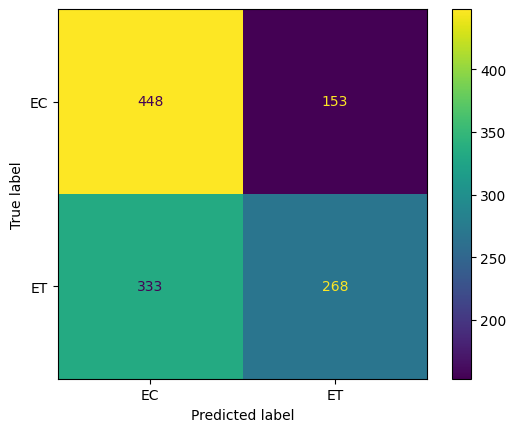

In [90]:
cat_features = ['customer_legal_form', 'product_code', 'supplier_legal_form']
model_catboost = CatBoostClassifier(
    n_estimators = 50,
    learning_rate = 0.1,
    max_depth = 5,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

In [92]:
#значимость признаков для леса
importances = model_catboost.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = x_train.columns
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[81.0116, 'time'],
 [6.2846, 'product_code'],
 [4.6574, 'price'],
 [4.4417, 'customer_legal_form'],
 [3.6047, 'supplier_legal_form']]

In [96]:
model_catboost.save_model(os.path.relpath("resources/catboost"))

История исполнителя

In [94]:
data

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
10822842,27682302,148300021111000023,2016-05-18T10:28:58.197+03:00,5048051080,75404,44225.56,2010-12-31,2011-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12200,5000000970,EC,366
10574775,26192470,348300110811000001,2016-02-16T11:11:34.220+03:00,5073008226,75401,119600.00,2011-01-01,2011-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12247,7736520080,EC,365
10515254,1430344,148300025311000004,2017-08-04T17:45:49.236+03:00,5010010751,75404,120000.00,2011-03-31,2011-06-01,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,5010036767,EC,63
5598402,36113119,173300003512000002,2019-03-20T10:48:10.416+03:00,7714070430,75404,1860000.00,2011-05-05,2012-04-01,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12200,7730055213,EC,333
4174761,7488372,327300009911000001,2016-02-17T11:31:41.521+03:00,3201003960,75403,204640.00,2011-06-01,2011-06-03,<Element '{http://zakupki.gov.ru/oos/types/1}c...,50000,5113000095,EC,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13107244,63075086,3424500105520000005,2021-01-26T14:28:52.063+07:00,4245001055,75403,47756.80,2020-12-08,2021-01-29,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,7017429425,EC,53
420777,62870668,3312010252120000027,2021-01-20T16:30:21.889+03:00,3120102521,75404,139000.00,2020-12-15,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,3123314130,EC,17
14716077,62776870,3190112923420000075,2021-01-19T11:19:14.402+07:00,1901129234,75404,178274.58,2020-12-16,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,1901064509,ET,16
12751051,62529379,3032333944020000147,2021-01-13T09:55:55.164+08:00,323339440,75404,937491.84,2020-12-25,2021-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,326540932,EC,372


In [155]:
supp = data[(data['supplier_inn'] == 726016530)]

In [156]:
print("Хорошо проведенные:",  len(supp[(supp['current_contract_stage'] == 'EC')]))

Хорошо проведенные: 19


In [157]:
print("Так себе проведенные:",  len(supp[(supp['current_contract_stage'] == 'ET')]))

Так себе проведенные: 4


In [158]:
supp

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
11211860,31887551,2071103152816000003,2017-01-23T18:29:55.688+03:00,711031528,75204,143094.13,2016-11-30,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,397
11309210,37858805,2072106342316000022,2017-12-05T16:10:48.072+03:00,725009184,75204,133934.73,2016-12-14,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,ET,383
11281166,39681638,3071104297817000004,2018-01-30T18:03:52.166+03:00,711042978,75404,783638.63,2017-01-01,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11228722,41900166,3071104333017000021,2018-05-14T11:52:08.186+03:00,711043330,75404,3928955.36,2017-02-13,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,322
11325935,41900166,3071104333017000021,2018-05-14T11:52:08.186+03:00,711043330,75404,3928955.36,2017-02-13,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,322
11260746,40956869,1071102644717000020,2018-04-03T16:20:43.693+03:00,711026447,30002,522737.48,2017-05-29,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,217
11295140,39568890,2072501475517000012,2018-01-25T12:15:10.753+03:00,725014755,75204,68718.39,2017-09-28,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,ET,460
11229892,46337997,3071104352318000005,2018-12-28T20:47:47.819+03:00,711043523,75404,1714771.30,2018-01-01,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11228991,46337997,3071104352318000005,2018-12-28T20:47:47.819+03:00,711043523,75404,1714771.30,2018-01-01,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11269693,50244719,2071104232918000003,2019-06-20T19:02:40.100+03:00,711042329,75203,124644.59,2018-01-01,2019-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,730


In [95]:
data[data['current_contract_stage']=='ET']

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
4471485,49217577,101300074013000009,2019-04-22T17:59:56.717+05:00,256016338,75404,147000.00,2013-01-01,2016-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,275038496,ET,1461
12890281,33617116,339300163413000012,2017-04-14T14:02:20.981+07:00,4223026610,75404,812608.50,2013-06-20,2013-12-01,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4220038945,ET,165
2334185,43660711,113300007314000017,2018-08-14T10:54:16.188+04:00,1835071691,75404,14648.00,2014-04-03,2014-12-01,30.02.16.194,12300,1835087194,ET,243
5598201,36218913,173300003514000003,2019-03-20T10:47:20.270+03:00,7714070430,75404,94942.00,2014-07-01,2014-12-01,72.60.10.000,12300,7736199349,ET,154
8684859,40735978,172300001914000051,2018-03-19T16:24:34.191+03:00,7825453050,75404,414630.00,2014-07-03,2014-12-01,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,7802137274,ET,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13115102,62200966,3424000680720000010,2020-12-28T15:54:39.692+07:00,4240006807,75403,141692.96,2020-11-18,2020-12-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4205262886,ET,43
11829127,62614308,3381901087120000013,2021-01-15T08:29:33.882+08:00,3819010871,75403,46620.00,2020-11-23,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12267,3840001848,ET,39
10049075,61614844,3504009579120000016,2020-12-28T12:51:46.637+03:00,5040095791,75403,101569.26,2020-11-24,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,7724364407,ET,38
11828822,62652893,3381901087120000014,2021-01-18T08:10:22.099+08:00,3819010871,75403,134760.44,2020-11-26,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12267,3840001848,ET,36
